<a href="https://colab.research.google.com/github/theozhangg/pocket_racers_assignments/blob/main/Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4

In Lab 4, we will be coding Linear and Logistic regression using only Numpy! You will also be asked to use what you know about gradient descent to tweak the algorithms for better results. While teams should collaborate and help each other, each member of a group should complete their own code.

This skeleton is intended to be somewhat sparse in order to give you the opportunity to become familiar with the intuition behind gradient descent and to make you very familiar with Numpy. Please reach out to us for any conceptual/mathematical questions or if you are stuck on something and need a hint - we don't want you spending hours on this!

If you are unfamiliar with Numpy, don't worry! There are a ton of great resources on it and the its documentation is very well-written (*cough cough* OpenCV). You can figure our how to do most things with a simple Google Search, but here are some functions, operators, etc. that I found useful in this lab:

    .dot() and @, .astype(), .T, unique(), mean(), sum(), inv(), pinv(), reshape(), vstack(), hstack(), .unique(), .concatenate(), .shape(), .any()

### Some notes on using Colab

If you've never used Colab before, this section is for you! Some things to note:

* The different boxes in this document are segments of Python code. Many of them contain errors and won't work if you try to run them right away (using the play button on the left). You need to fill in the blanks to make them work!

* If you update a block of code, even if you re-run it, you must also re-run all the blocks after it up to the point where you're currently working. They don't run themselves!

In [2]:
import numpy as np
import csv
from numpy.core.memmap import dtype
import matplotlib.pyplot as plt

# You may use these sklearn tools in your implementation, but no others.
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
WEATHER_PATH = "/content/drive/MyDrive/Copy of Lab 4/weatherHistory.csv"
data = np.loadtxt(WEATHER_PATH, delimiter=",", dtype=str)
data = data[:,1:-1]
header = data[0]
data = data[1:]

##Part 1: Single line fit!

In this part of the lab, you will be using only the humidity data to estimate the temperature using linear regression. Then we well compare the results of a single feature linear regression with the closed form solution. Experiment with the learning rate and number of itterations and try to find the optimal learning rate for 40 itterations (we got it to 59.5).

In [6]:
# Right now, the data is in one large matrix. Seperate out x as the humidity
# and y as the temperature.

x = data[:, 4]
y = data[:, 2]
#print(x, y)
x = x.astype('float')
y = y.astype('float')

In [7]:
# Code the mean squared error function given x, y, a, and b.
def MSE(x, y, a, b):
  y_hat = a * x + b
  return np.mean((y_hat - y)**2)

# Code the gradient descent function. This will return the new values of a and b
# after the gradient has been calculated and the learning rate has been applied.
def grad_des(x, y, a, b):
  d_a = np.mean(-2 * y * x + 2 * a * x ** 2 + 2 * x * b)
  d_b = np.mean(-2 * y + 2 * a * x + 2 * b)
  return (d_a, d_b)

Final Training Loss: 59.49025579624444


Text(0.5, 1.0, 'single feature loss over time')

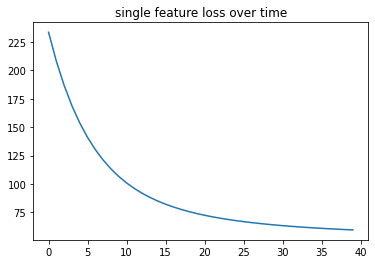

In [14]:
# Initialize a and b.
a = 0
b = 0
lr = .614
losses = []
for i in range(40):
  losses.append(MSE(x, y, a, b))
  # Update a and b using the values from your gradient descent function.
  d_a, d_b = grad_des(x,y,a,b)
  new_a = a - lr * d_a
  new_b = b - lr * d_b
  a, b = new_a, new_b

print(f"Final Training Loss: {losses[-1]}")
plt.plot(losses)
plt.title("single feature loss over time")

This is your **loss graph**. Hang onto it, because you'll need it later for the checkoff.

In addition, remember what we taught you guys about how your training should improve the loss: it should decay towards a minimum as the gradient descent iterations continue. Pay attention to the y-axis here, which indicates the loss. If your error blows up towards infinity or doesn't decrease very quickly, you should be able to recognize and rectify the issue with your hyperparameters!

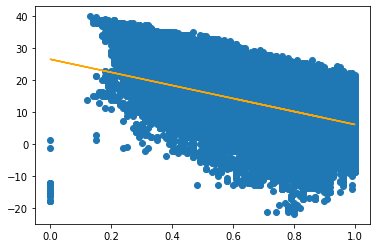

In [9]:
# Let's take a look at what our line of best fit looks like!
plt.scatter(x, y)
plt.plot(x, a*x+b, color='orange')

In [10]:
# Now let's find the true optimal solution using the closed form equation. Use
# np.polyfit or other such functions only to check your work.
# Don't forget what you need to add to the X matrix in order for the closed form
# to work!

#need to add the extra 1's for bias
new_x = np.c_[x, np.ones(x.size)]
#@ means multiplication of two matrices
#inv means mult inverse of a matrix
#T menas transpose, put it on its side
th = np.linalg.inv(new_x.T @ new_x) @ new_x.T @ y
a1, b1 = th

Grad Desc:   a: -20.34677104584479 b: 26.451514496623805 MSE: 59.2010272881167
Closed form: a: -30.894383758050832 b: 34.63692912688918 MSE: 54.761829807719856
Poly Fit:    a: -30.894383758051426 b: 34.63692912688962


Text(0.5, 1.0, 'closed and gd best fit lines')

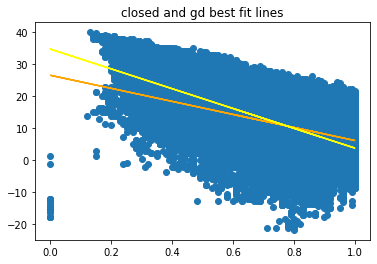

In [13]:
# Compare our closed form with our gradient descent. The closed form solution
# should be the same thing as the result of polyfit.

a2, b2 = np.polyfit(x, y, 1)
print(f"Grad Desc:   a: {a} b: {b} MSE: {MSE(x, y, a, b)}")
print(f"Closed form: a: {a1} b: {b1} MSE: {MSE(x, y, a1, b1)}")
print(f"Poly Fit:    a: {a2} b: {b2}")

plt.scatter(x, y)
plt.plot(x, a*x+b, color='orange')
plt.plot(x, a1*x+b1, color='yellow')
plt.title("closed and gd best fit lines")

To get checked off for this part, show us you:
- loss graph
- the graph with your 2 best fit lines
- the final MSE for your gradient descent and closed form solutions
- your grad_des function

##Part 2: Multiple input features

In this part we will modify our gradient descent function to accept all of the possible input features. This will require converting the precipitation type and weather summaries to one-hot encodings (see slides 20-25 and 33). Then we will have to change our equations to be in matrix notation.

In [12]:
# First, lets get our x and y data one-hot encoded.
# hot_X should be the data where the categorical fields are converted into
#     one-hot encodings (temperature data excluded). 
# As a sanity check, the dimensions should be (96453, 38).
# hot_y should still just be the temperature data.
def encode_onehot(array):
  #have to get the unique values of each column to use them as values to encode
  #return indices of the first instances of the unique values as well
  unique, inverse = np.unique(array, return_inverse=True)
  #now make a matrix where the 1's correlate to the category
  onehot = np.eye(unique.shape[0])[inverse]
  return onehot

summaries_onehot = encode_onehot(data[:, 0])
precip_onehot = encode_onehot(data[:, 1])

hot_X = np.c_[summaries_onehot, precip_onehot, data[:, 2:]].astype(float)
hot_y = np.c_[y].astype(float)

Now update your gradient descent and Mean Squared Error function to be able to learn from multiple features. See how low you can get the error after 40 iterations.

You may notice a higher error than we got in part 1, especially when compared with an extrememly low closed form error. Think about why this may be the case and what hyperparameters you can tune to improve this.

In [15]:
def grad_des2(X, y, theta, learning_rate):
  grad_L = 1 / y.shape[0] * (-2 * X.T @ y + 2 * X.T @ X @ theta)
  return theta - learning_rate * grad_L

def MSE2(X, y, theta):
  error = 1 / y.shape[0] * (y - X @ theta).T @ (y - X @ theta)
  return error[0][0]

theta = np.zeros((len(hot_X[0]), 1))
MSE2(hot_X, hot_y, theta)

233.6199059383237

Final Training Loss: 90.31415451658769


Text(0.5, 1.0, 'Multi feature loss over time')

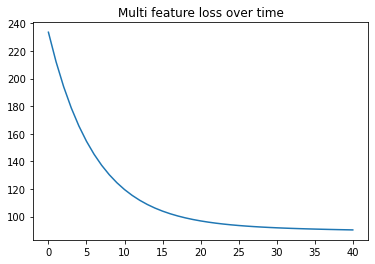

In [25]:
learning_rate = 0.00000091

theta = np.zeros((len(hot_X[0]), 1))

losses = []
losses.append(MSE2(hot_X, hot_y, theta))

for i in range(40):
  theta = grad_des2(hot_X, hot_y, theta, learning_rate)
  losses.append(MSE2(hot_X, hot_y, theta))
  
print(f"Final Training Loss: {losses[-1]}")
plt.plot(losses)
plt.title("Multi feature loss over time")

In [28]:
# Now solve for theta using the closed form and compare your final training loss between
# the closed form and regression solution

#can't really inverse a singular matrix (det does not exist) so use pinv
th2 = np.linalg.pinv(hot_X.T @ hot_X) @ hot_X.T @ hot_y
MSE2(hot_X, hot_y, th2)

1.3543407450298143e-19

As you can (probably) see, the gradient descent error is worse than the single input version and much worse than the closed form solution. Think about why this is and how can improve it (hint: we talked about this technique in our lecture). Copy your code above into the cell below to make any modifications to improve your gradient descent!

Final Training Loss: 92.25375277793233


Text(0.5, 1.0, 'Modified multi feature loss over time')

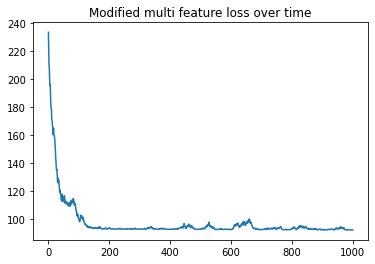

In [38]:
#running it on multiple inputs means way more data points
#so, you can do minibatching instead
learning_rate = 0.00000001

theta = np.zeros((len(hot_X[0]), 1))

losses = []
losses.append(MSE2(hot_X, hot_y, theta))

BATCH_SIZE = 15

for i in range(1000):
  #make a minibatch
  #first find a random place to start in the hot_x
  start = np.random.randint(0, hot_X.shape[0])
  #make a subset of it using the batch size
  subset_X = hot_X[start:start+BATCH_SIZE]
  subset_y = hot_y[start:start+BATCH_SIZE]
  #update the values with the minibatch
  theta = grad_des2(subset_X, subset_y, theta, learning_rate)
  losses.append(MSE2(hot_X, hot_y, theta))

print(f"Final Training Loss: {losses[-1]}")
plt.plot(losses)
plt.title("Modified multi feature loss over time")

To get checked off for this part, show us:
- both of you loss graphs
- closed form error
- your code for both GD algorithms
- an explaination of what you changed and why


##Part 3: Logistic Regression and K-fold Cross Validation

In this part of the lab you will be esimating if someone will suffer a heart attack in the next 10 years based on health statistics. This time, we will be using K-fold cross validation to determine the viability of our model. In lecture, we did not give you the full equation for logistic regression, I suggest deriving it before starting that part of the lab. Try to do it yourself! (The answer should be **simple** - if you are coding a disgusting equation, that is wrong and you should stop.)

In [40]:
HAM_PATH = "/content/drive/MyDrive/Copy of Lab 4/framingham.csv"
health_data = np.loadtxt(HAM_PATH, delimiter=",", dtype=str)

# But wait! The data is not complete! Take a look to see what is wrong with it
# and remove any offending datapoints (rows) - this is the "cleaning" stage of
# the ML pipeline.
# Challange: do this in one line.

#tilde means logical not, the any(1) means look row wise and checks if any value is true and only keeps it if true
health_data = health_data[~(health_data == "NA").any(1), :]

In [41]:
# Create your X and Y data and clean it! Binarize the assigned-sex-at-birth
# column and add the bias term to your X data

health_x = health_data[1:,1:-1]
#add the 1's for the bias term
health_x = np.c_[health_x, np.ones(health_x.shape[0])]
health_y = health_data[1:,-1]

#Clean it up!

health_x = health_x.astype('double')
health_y = health_y.astype('double')

In [42]:
# Separate your training data into 5 folds for cross validation

X_train, X_test, y_train, y_test = train_test_split(health_x, health_y, test_size=0.2, random_state=0)
X_train, y_train = shuffle(X_train, y_train)
k = 5

X_folds = np.array_split(X_train,k)
y_folds = np.array_split(y_train, k)


# A quick check:
for fold in range(k):
  print(X_folds[fold].shape)
  print(y_folds[fold].shape)

(585, 15)
(585,)
(585, 15)
(585,)
(585, 15)
(585,)
(585, 15)
(585,)
(584, 15)
(584,)


In [53]:
# Now lets code all of our relevant equations.

def sigmoid(x):
  sig = 1 / (1 + np.exp(-x))
  return sig

def accuracy(X, y, theta): 
  diff = np.abs(y - np.round(sigmoid(X @ theta))) 
  return np.mean(np.where((diff) == 0, 1, 0))

def cross_entropy_loss(X, y, theta):
    y_hat = sigmoid(X @ theta)
    loss = -y @ np.log(y_hat)-(1-y) @ np.log(1-y_hat+.0001)
    return np.mean(loss)

def log_grad_desc(X, y_hat, y, lr):
  gradient = 1 / y.shape[0]*(X.T @ (y_hat-y))
  return theta - lr * gradient

In [55]:
# Now lets validate our model. Use the validation error to tune your
#hyperparameters. Also, compare your validation and training errors

lr = .000001

val_losses = []
train_losses = []
for fold in range(k):
  theta = np.random.randn(health_x.shape[1]) # Reinitialize theta

  # Set your validation and training datasets
  X_val = X_folds[fold]
  y_val = y_folds[fold]
  X_train = np.vstack(np.delete(X_folds, fold))
  y_train = np.hstack(np.delete(y_folds, fold))
  for i in range(5000):
    theta = log_grad_desc(X_train, sigmoid(X_train @ theta), y_train, lr)
    pass
    
  val_losses.append(cross_entropy_loss(X_val, y_val, theta))
  train_losses.append(cross_entropy_loss(X_train, y_train, theta))


print(f"train_losses: {sum(train_losses)/len(train_losses)}")
print(f"val_losses: {sum(val_losses)/len(val_losses)}")

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


train_losses: 55260.220556994886
val_losses: 13869.06720531177


In [59]:
# Training - once you have tuned your hyperparameters, train your model once
# more on all the training data and then test it on the test dataset

lr = .005
theta = np.random.randn(health_x.shape[1])

for i in range(5000):
  #Gradient Descent
  theta = log_grad_desc(X_train, sigmoid(X_train @ theta), y_train, learning_rate)
  pass

print(f"Testing Accuracy: {accuracy(X_test, y_test, theta)}")

Testing Accuracy: 0.73224043715847


To be checked off for this part, show us your code for gradient descent and the resulting outputs and losses.